# Predicting Heart Disease Risk Using the K-Nearest Neighbors

## Table of Contents

- [1. Introduction](#1.-Introduction)
- [2. EDA: Descriptive Statistics](#2.-EDA:-Descriptive-Statistics)
- [3. EDA: Visualizations](#3.-EDA:-Visualizations)
- [4. Data Cleaning](#4.-Data-Cleaning)
- [5. Feature Selection](#5.-Feature-Selection)
- [6. Building a Classifier with One Feature](#6.-Building-a-Classifier-with-One-Feature)
- [7. Building a Classifier with Multiple Features](#7.-Building-a-Classifier-with-Multiple-Features)
- [8. Hyperparameter Tuning with GridSearchCV](#8.-Hyperparameter-Tuning-with-GridSearchCV)
- [9. Impact of Gender Imbalance on Performance](#9.-Impact-of-Gender-Imbalance-on-Performance)
- [10. Conclusion](#10.-Conclusion)

## 1. Introduction

The [World Health Organization](https://en.wikipedia.org/wiki/World_Health_Organization) (WHO) estimates that `17.9` million people die from [cardiovascular diseases](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)) (CVDs) every year. Multiple risk factors can contribute to CVD in an individual, such as an unhealthy diet, lack of physical activity, and mental illness. Identifying these risk factors early can help prevent many premature deaths.

In this project, we will assume to be working for an R&D company focused on providing healthcare solutions. The company has collected anonymized data from multiple hospitals regarding several patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes relevant information for each patient, such as personal details and medical data, including whether or not they have had heart disease previously.

Our task is to use the dataset to accurately predict the likelihood of a new patient developing heart disease in the future. The dataset has the following features:

- `Age` – Age of the patient **[years]**.
- `Sex` – Sex of the patient **[`M`: Male, `F`: Female]**.
- `ChestPainType` – Type of chest pain **[`TA`: Typical Angina, `ATA`: Atypical Angina, `NAP`: Non-Anginal Pain, `ASY`: Asymptomatic]**.
- `RestingBP` – Resting blood pressure **[mm Hg]**.
- `Cholesterol` – Serum cholesterol **[mg/dL]**.
- `FastingBS` – Fasting blood sugar **[`1`: > 120 mg/dL, `0`: otherwise]**.
- `RestingECG` – Resting electrocardiogram results **[`Normal`: Normal, `ST`: ST-T wave abnormality, `LVH`: probable or definite left ventricular hypertrophy by Estes' criteria]**.
- `MaxHR` – Maximum heart rate **[between `60` and `202`]**.
- `ExerciseAngina` – Exercise-induced angina **[`Y`: Yes, `N`: No]**.
- `Oldpeak` – ST depression value.
- `ST_Slope` – Slope of the peak exercise ST segment **[`Up`: upsloping, `Flat`: flat, `Down`: downsloping]**.
- `HeartDisease` – Output class **[`1`: heart disease, `0`: normal]**.

Before we build our **K-Nearest Neighbors** classifier, we're going to import the relevant libraries and conduct exploratory data analysis on the dataset.

In [1]:
# Import the relevant libraries
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the heart disease prediction dataset and display the first few rows
df = pd.read_csv("Datasets/heart_disease_prediction.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


After examining the first few rows of the dataset, we observe that it contains both categorical and numerical features.

## 2. EDA: Descriptive Statistics

Now, let's identify which columns are numerical and which are categorical.

In [2]:
# Display the data types of the columns and the count of each data type
display(df.dtypes)
display(df.dtypes.value_counts())

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

int64      6
object     5
float64    1
Name: count, dtype: int64

In total, `7` features are numerical, while `5` are categorical. However, two of the numerical features, `FastingBS` and `HeartDisease`, are actually categorical as well because they contain only the values `0` and `1`. Next, let's examine the numerical variables.

In [3]:
# Display summary statistics for the numerical features
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the table above, we can observe that:

- The average age of patients is around `54` years.
- The median cholesterol level is roughly `24` mm/dL higher than the mean, suggesting a left-skewed distribution with potential outliers.
- `RestingBP` and `Cholesterol` have a minimum value of `0`.

`RestingBP` represents resting blood pressure, and a value of `0` is unlikely. Similarly, according to the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol is a composite measure, including `HDL`, `LDL`, and `20%` of triglyceride levels, making a value of `0` improbable for serum cholesterol.

Next, let's quickly check for any missing values in the dataset.

In [4]:
# Check for missing values in each column of the dataset
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Fortunately, there are no missing values in the dataset.

## 3. EDA: Visualizations

Our observations so far have been limited to a subset of the columns. Additionally, we don't yet know how the dataset is distributed in relation to our target variable, `HeartDisease`. For instance, how many female patients had heart disease?

Next, we’ll explore the categorical features and use visualizations to better understand the distribution of the data.

In [5]:
# Display summary statistics for categorical features
display(df.describe(include=['object']))

# Display unique values for 'FastingBS' and 'HeartDisease' columns
df["FastingBS"].unique(), df["HeartDisease"].unique()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

The `Sex` and `ExerciseAngina` columns have two unique values, with `M` and `N` being the most frequent, respectively. `ChestPainType` includes four categories, with `ASY` being the most common. Moreover, `RestingECG` and `ST_Slope` have three possible values, with `Normal` and `Flat` being the most frequent.

The unique values for both `FastingBS` and `HeartDisease` are `0` and `1`, indicating they represent two-class categorical variables.

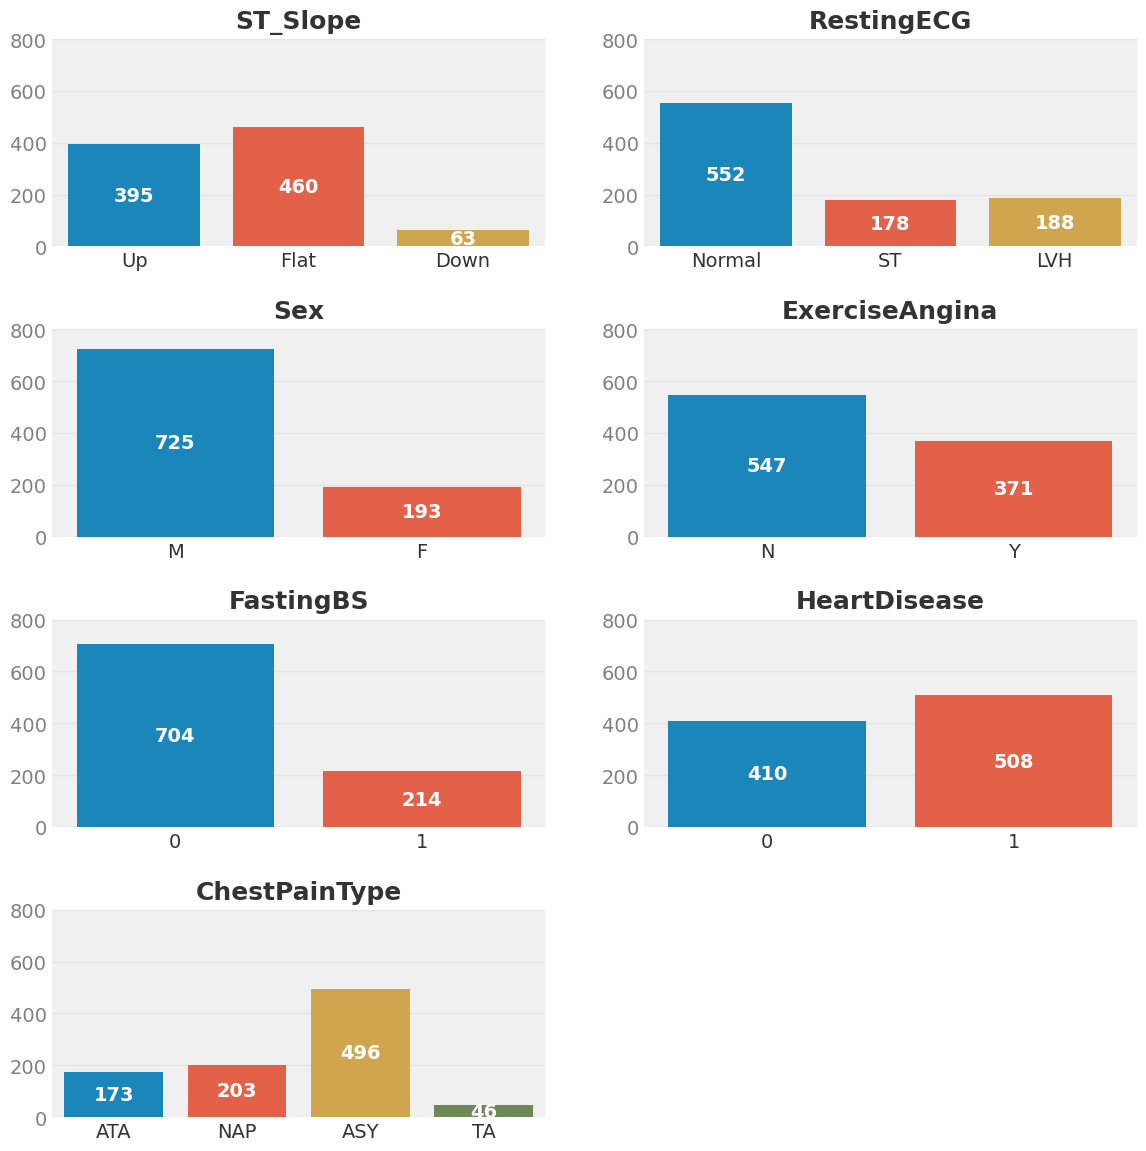

In [6]:
# Define the categorical columns
categorical_cols = ["ST_Slope", "RestingECG", "Sex", "ExerciseAngina",
                    "FastingBS", "HeartDisease", "ChestPainType"]

# Set the figure size and style
fig = plt.figure(figsize=(14, 14))
plt.style.use('fivethirtyeight')

# Iterate through each categorical column to create subplots
for i, col in enumerate(categorical_cols, start=1):
    ax = plt.subplot(4, 2, i)
    sns.countplot(x=df[col], ax=ax)

    # Remove all spines as well as x and y-axis ticks
    ax.spines[:].set_visible(False)
    ax.tick_params(axis='both', bottom=False, left=False)
    
    # Set title and remove x and y-axis labels
    ax.set_title(col, weight='bold', color='#333333', size=18, pad=8)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set y-axis limits and add horizontal grid lines
    ax.set_ylim(0, 800)
    ax.yaxis.grid(True, alpha=0.3)

    # Adjust x and y-axis labels' color
    ax.xaxis.set_tick_params(labelcolor='#333333')
    ax.tick_params(axis='y', labelcolor='grey')
    
    # Add bar labels to each container
    for container in ax.containers:
        ax.bar_label(container, label_type="center", color='white', weight='bold')

# Adjust layout to add vertical space between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()

From the subplots above, here are some insights:
- The dataset is highly skewed toward male patients, with `725` males and `193` females. This could potentially induce bias in our models.
- `496` patients had `ASY` (asymptomatic) chest pain type.
- `552` patients had a `normal` resting ECG.
- `704` patients had fasting blood sugar lower than `120` mg/dL.

Next, grouping each category by `HeartDisease` will give us a better idea about the data distribution.

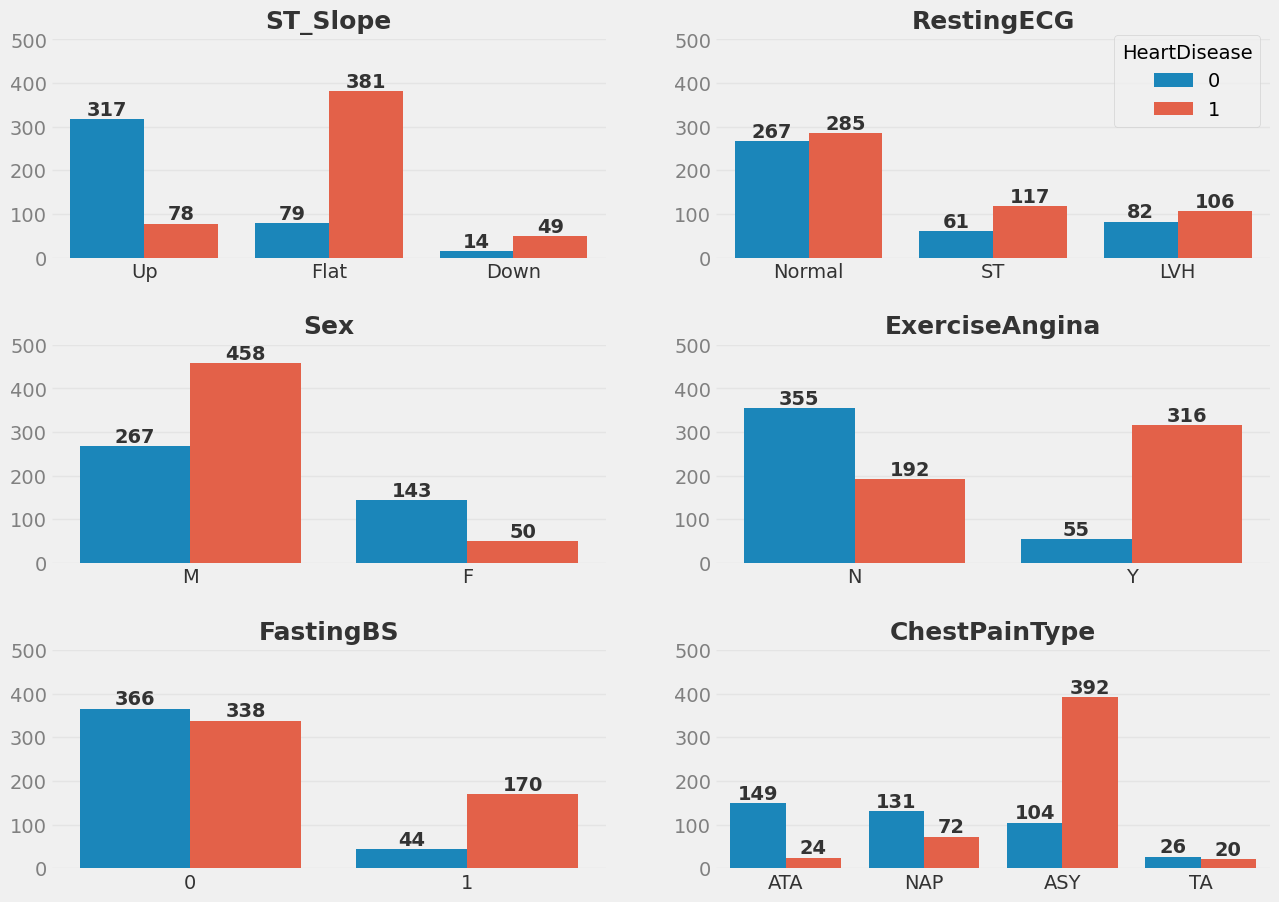

In [7]:
# Set the figure size
fig = plt.figure(figsize=(14, 14))

# Plot countplots for each categorical column, with hue based on 'HeartDisease'
for i, col in enumerate(["ST_Slope", "RestingECG", "Sex",
                         "ExerciseAngina", "FastingBS", "ChestPainType"], start=1):
    ax = plt.subplot(4, 2, i)
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)

    # Remove all spines as well as x and y-axis ticks
    ax.spines[:].set_visible(False)
    ax.tick_params(axis='both', bottom=False, left=False)
    
    # Set title and remove x and y-axis labels
    ax.set_title(col, weight='bold', color='#333333', size=18, pad=8)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set y-axis limits and add horizontal grid lines
    ax.set_ylim(0, 500)
    ax.yaxis.grid(True, alpha=0.3)

    # Adjust x and y-axis labels' color
    ax.xaxis.set_tick_params(labelcolor='#333333')
    ax.tick_params(axis='y', labelcolor='grey')
    
    # Add bar labels to each container
    for container in ax.containers:
        ax.bar_label(container, color='#333333', weight='bold')
        
# Remove all legends and add one legend in the top right
for ax in fig.axes:
    ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, fontsize='medium', title='HeartDisease', bbox_to_anchor=(0.95, 0.89))

# Adjust layout to add vertical space between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()

From the subplots above, we observe the following:

- Only `50` female patients have been diagnosed with heart disease compared to `143` males.
- A significant number of patients (`392`) diagnosed with heart disease have asymptomatic (`ASY`) chest pain. While chest pain could be a relevant feature for our models, asymptomatic implies that patients who had heart disease did not have chest pain as a symptom.
- A high number of patients (`170`) with blood sugar greater than `120` mg/dL were diagnosed with heart disease compared to those who were not.
- Out of all patients who had exercise-induced angina, `316` were diagnosed with heart disease.
- Out of all patients with a flat ST slope, `381` were diagnosed with heart disease.

Looking at the data distribution, we can start to identify some relevant features. We will clean up the dataset before narrowing down our features.

## 4. Data Cleaning

Previously, we found that there are no missing values in our entire dataset. However, a few columns have `0` values that don't make sense. There are a few ways we can handle these values:

1. Remove those rows entirely if their frequency of occurrence is low.
2. Impute those `0s` with either the median value of the entire column, or the median value based on the `HeartDisease` status.
3. Use more complex approaches, such as looking at the median of the values grouped by age, sex, and/or resting ECG of the patient. For example, the resting blood pressure of a female in her `30s` with a normal ECG might be lower than the median of the entire `RestingBP` column.

The third option might give us a slightly more accurate result, but given the small size of our dataset, we can ignore it for now.

In [8]:
# Print the number of rows where 'RestingBP' or 'Cholesterol' is 0
print(f'The number of rows where "RestingBP" is 0: {df[df["RestingBP"] == 0].shape[0]}')
print(f'The number of rows where "Cholesterol" is 0: {df[df["Cholesterol"] == 0].shape[0]}')

The number of rows where "RestingBP" is 0: 1
The number of rows where "Cholesterol" is 0: 172


`RestingBP` has only `1` zero value, which we can just remove. On the other hand, there are `172` zero values for `Cholesterol`, which is a relatively high number. Hence, removing all these rows isn't practical.

Although it might not be ideal, we will replace the zero values in `Cholesterol` based on the `HeartDisease` status. Specifically, the zero values in `Cholesterol` for patients diagnosed with heart disease will be replaced by the median of non-zero `Cholesterol` values for patients with heart disease. Similarly, zero values for patients without heart disease will be replaced by the median of non-zero `Cholesterol` values for patients without heart disease.

In [9]:
# Create a copy of the DataFrame and remove rows where 'RestingBP' is 0
df_clean = df.copy()
df_clean = df_clean[df_clean["RestingBP"] != 0]

# Create a mask for rows where 'HeartDisease' is 0
hd_mask = df_clean["HeartDisease"] == 0

# Extract cholesterol values based on heart disease status
chol_without_hd = df_clean.loc[hd_mask, "Cholesterol"]
chol_with_hd = df_clean.loc[~hd_mask, "Cholesterol"]

# Impute zero values in 'Cholesterol' with the median of respective groups
df_clean.loc[hd_mask, "Cholesterol"] = chol_without_hd.replace(0, chol_without_hd.median())
df_clean.loc[~hd_mask, "Cholesterol"] = chol_with_hd.replace(0, chol_with_hd.median())

# Display summary statistics for 'Cholesterol' and 'RestingBP'
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


As expected, the minimum values for both columns have changed. There are no more zero values in both `Cholesterol` and `RestingBP`.

## 5. Feature Selection

Now that we've cleaned our data, we can explore how the columns correlate with one another. Before that, we'll convert categorical columns into dummy variables.

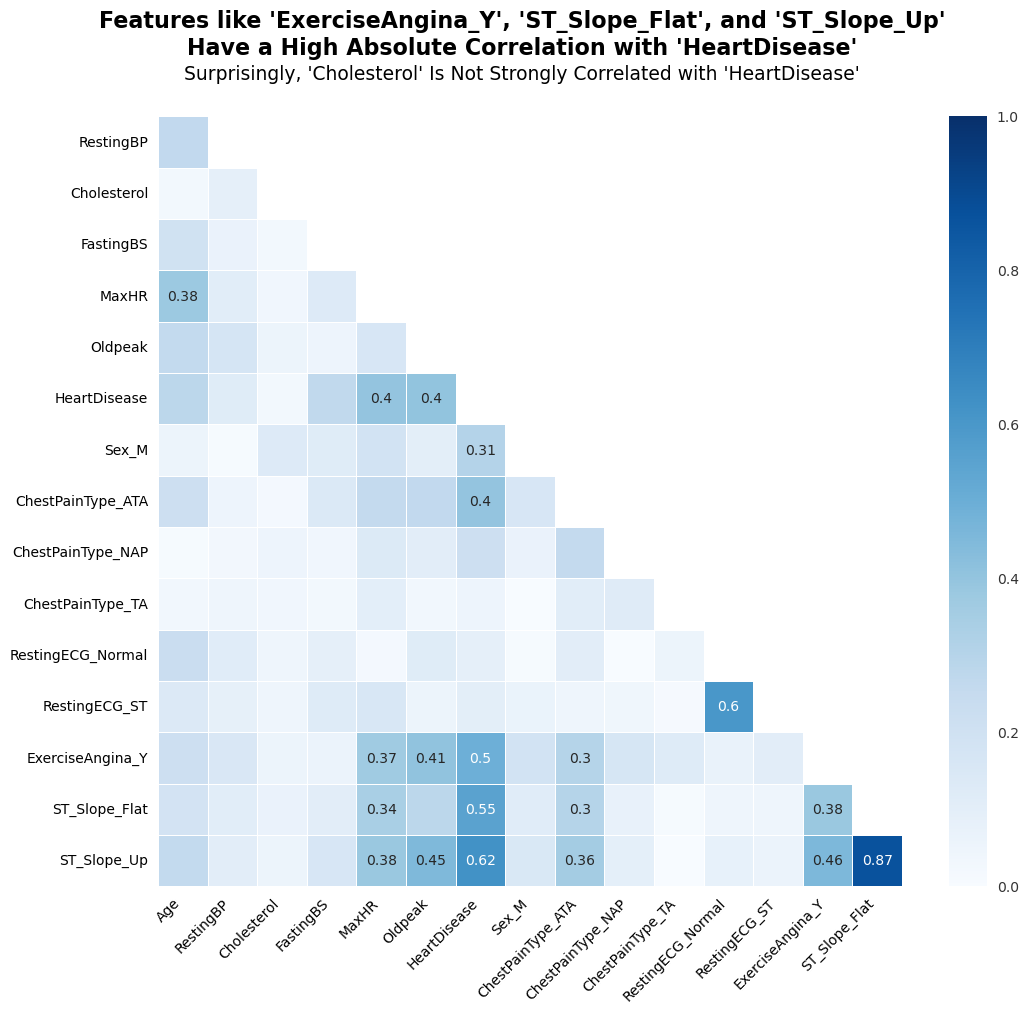

In [10]:
# Convert categorical columns to dummy variables
df_clean = pd.get_dummies(df_clean, drop_first=True)

# Compute absolute correlations and reset plot style
correlations = abs(df_clean.corr())
plt.style.use('default')

# Create a mask to hide the upper triangle of the heatmap
mask = np.zeros_like(correlations.iloc[1:, :-1])
mask[np.triu_indices_from(mask, k=1)] = True

# Create a heatmap showing correlations between features with annotations
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(correlations.iloc[1:, :-1], annot=True, annot_kws={"size": 10},
                 vmin=0, vmax=1, linewidths=0.5, cmap="Blues", fmt=".2f", mask=mask)

# Set title and subtitle
ax.set_title("Features like 'ExerciseAngina_Y', 'ST_Slope_Flat', and 'ST_Slope_Up'\n\
Have a High Absolute Correlation with 'HeartDisease'", 
             x=0.49, y=1.07, fontsize=16, ha='center', weight='bold')
ax.text(s="Surprisingly, 'Cholesterol' Is Not Strongly Correlated with 'HeartDisease'",
        x=7.33, y=-0.72, fontsize=13.5, ha='center')

# Customize tick parameters and labels, and rotate x-tick labels
ax.tick_params(left=False, bottom=False)
ax.tick_params(axis='both', labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust annotations and hide values lower than 0.3
for text in ax.texts:
    t = text.get_text()
    # Check if the text can be converted to float
    try:
        t = float(t)
        if t < 0.3:
            text.set_text('')  # Hide annotations for values lower than 0.3
        else:
            text.set_text(t)   # Keep annotations for values greater than or equal to 0.3
    except:
        pass  # Skip non-numeric annotations

# Adjust the size and color of the colorbar values, and remove tick marks
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelcolor='#333333', labelsize=10, right=False)

# Display the plot
plt.show()

From our correlation heatmap, we can identify the following features as being correlated (absolute correlation coefficient greater than `0.3`) with `HeartDisease`: `ChestPainType_ATA`, `ExerciseAngina_Y`, `ST_Slope_Flat`, `ST_Slope_Up`, `Oldpeak`, `Sex_M`, and `MaxHR`.

We chose the correlation coefficient threshold arbitrarily. Surprisingly, `Cholesterol` is not strongly correlated with `HeartDisease`, so we can consider ignoring this feature for now. Based on our findings so far, we will narrow down our features to `ExerciseAngina_Y`, `ST_Slope_Flat`, `ST_Slope_Up`, `Oldpeak`, and `Sex_M`.

Although `Sex_M` has an absolute correlation coefficient of only `0.31`, we'll include it based on our EDA observations. Next, we'll create our models using these features.

## 6. Building a Classifier with One Feature

To build a classifier using only a single feature, we'll split the dataset into training and test sets. We'll then create a model for each selected feature and evaluate their performance using accuracy as the metric.

In [11]:
# Set up the features (X) and target (y) variables
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Select specific features to evaluate
features = ["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Oldpeak", "Sex_M"]

# Loop through each feature for k-NN classification
for feature in features:
    
    # Initialize k-NN classifier with k=3 and train on the selected feature
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[[feature]], y_train)
    
    # Calculate training and test accuracy
    train_accuracy = knn.score(X_train[[feature]], y_train)
    test_accuracy = knn.score(X_test[[feature]], y_test)
    
    # Print the training and testing accuracy for the current feature
    print(f'The classifier trained on "{feature}" achieved {train_accuracy*100:.2f}% train accuracy \
and {test_accuracy*100:.2f}% test accuracy')

The classifier trained on "ExerciseAngina_Y" achieved 53.42% train accuracy and 60.87% test accuracy
The classifier trained on "ST_Slope_Flat" achieved 78.02% train accuracy and 76.09% test accuracy
The classifier trained on "ST_Slope_Up" achieved 82.10% train accuracy and 79.13% test accuracy
The classifier trained on "Oldpeak" achieved 54.29% train accuracy and 50.43% test accuracy
The classifier trained on "Sex_M" achieved 64.63% train accuracy and 67.83% test accuracy


The classifiers trained on `ST_Slope_Flat` and `ST_Slope_Up` performed best overall, with test accuracies of `76.09%` and `79.13%`, respectively. `ExerciseAngina_Y` and `Oldpeak` had the lowest test accuracies, with a noticeable gap between train and test performance for `ExerciseAngina_Y`, indicating that the model performed better on the test set.

As a result, we're going to train a classifier by omitting `Oldpeak` to optimize performance and minimize overfitting.

## 7. Building a Classifier with Multiple Features

Before training on the selected features, it's important to note that they aren't yet normalized. Since the values are not all within the same range, we will first scale our selected features to the range `(0,1)` before training our baseline k-NN model.

In [12]:
# Initialize MinMaxScaler and define the selected features
scaler = MinMaxScaler()
features = ["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Sex_M"]

# Scale the training and test data for the selected features
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

# Train k-NN classifier with k=3 on the scaled data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Calculate and print training and testing accuracy
train_accuracy = knn.score(X_train_scaled, y_train)
test_accuracy = knn.score(X_test_scaled, y_test)
print(f"Baseline k-NN train accuracy: {train_accuracy*100:.2f}%", "\t", \
      f"Baseline k-NN test accuracy: {test_accuracy*100:.2f}%")

Baseline k-NN train accuracy: 84.86% 	 Baseline k-NN test accuracy: 82.61%


The baseline k-NN model's performance on the combined features surpasses the previous results from using single features, with train and test accuracies of `84.86%` and `82.61%`. This suggests that combining features improved the model's accuracy. Next, we'll explore which hyperparameters might be optimal for further improvement using the same four features.

## 8. Hyperparameter Tuning with GridSearchCV

`GridSearchCV` enables us to explore various hyperparameters for our model. For instance, with the `KNeighborsClassifier`, we can experiment with parameters such as `n_neighbors`, `weights`, and `metric`.

Since `GridSearchCV` employs a cross-validation approach, it provides a more reliable estimate of the model's performance compared to a regular train-test split.

In [13]:
# Define hyperparameter grid for KNeighborsClassifier
grid_params = {"n_neighbors": range(1, 20),
               "metric": ["minkowski", "manhattan"],
               "weights": ["uniform", "distance"],
               "leaf_size": range(10, 50, 10)}

# Initialize KNeighborsClassifier and perform grid search for hyperparameter tuning
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

# Print the best cross-validation score and corresponding hyperparameters for the tuned k-NN model
print(f'Tuned k-NN best cross-validation score: {knn_grid.best_score_ * 100:.2f}%')
print(f'Best parameters: {knn_grid.best_params_}')

Tuned k-NN best cross-validation score: 84.70%
Best parameters: {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}


The best cross-validation score from the grid search is `84.70%`, indicating improved performance compared to the baseline k-NN test accuracy of `82.61%`. The optimal hyperparameters are `leaf_size: 20`, `metric: minkowski`, `n_neighbors: 1`, and `weights: uniform`, suggesting effective tuning for the classifier.

Next, let's evaluate our best model from the grid search on the train and test datasets.

In [14]:
# Generate training and testing set predictions using the best estimator from grid search
train_predictions = knn_grid.best_estimator_.predict(X_train_scaled)
test_predictions = knn_grid.best_estimator_.predict(X_test_scaled)

# Calculate and print the training and test accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Tuned model train accuracy: {train_accuracy*100:.2f}%", "\t", \
      f"Tuned model test accuracy: {test_accuracy*100:.2f}%")

Tuned model train accuracy: 84.86% 	 Tuned model test accuracy: 82.61%


The tuned model's performance mirrors the baseline k-NN, with identical train (`84.86%`) and test (`82.61%`) accuracy, despite the cross-validation score of `84.70%`. This suggests that the hyperparameter tuning didn't improve generalization over the baseline model.

## 9. Impact of Gender Imbalance on Performance

To explain the potential reason for the slightly lower test accuracies of the baseline and optimized models compared to their training accuracies, let's first check the distribution of patients by sex in our data.

In [15]:
# Print the distribution of patients by sex in the training and test datasets
print("Distribution of patients by sex in the training dataset:")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by sex in the test dataset:")
print(X_test.Sex_M.value_counts())

Distribution of patients by sex in the training dataset:
Sex_M
True     538
False    149
Name: count, dtype: int64

Distribution of patients by sex in the test dataset:
Sex_M
True     186
False     44
Name: count, dtype: int64


We used sex as one of our features for training our models, with the training dataset (`X_train`) consisting of `538` males and `149` females, and the test dataset (`X_test`) containing `186` males and `44` females.

The gender imbalance in both datasets likely impacted the train and test accuracies. With a larger proportion of males, a model may become biased toward predicting outcomes for this majority group, leading to inflated accuracy for males but poorer performance for females. Furthermore, this imbalance can cause a model to overfit, relying more on male-specific patterns while underrepresenting female characteristics.

Based on the tuned model, let's create DataFrames to compare the actual and predicted values for both the training and test sets, calculate the percentage of correct and incorrect predictions by gender, and analyze the results.

In [16]:
# Create DataFrames to compare actual and predicted values for train and test sets
train_comparison = pd.DataFrame({'Actual': y_train, 'Predicted': train_predictions})
test_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})

# Add gender column to the comparison DataFrames and map True/False to 'Male'/'Female'
train_comparison['Gender'] = X_train['Sex_M'].copy()
train_comparison['Gender'] = train_comparison['Gender'].map({True:'Male', False:'Female'})
test_comparison['Gender'] = X_test['Sex_M'].copy()
test_comparison['Gender'] = test_comparison['Gender'].map({True:'Male', False:'Female'})

# Calculate the percentage of correct and incorrect predictions by gender for train and test sets
train_gender_comparison = train_comparison.groupby('Gender').apply(
    lambda df: pd.Series({
        'Correct (%)': (df['Actual'] == df['Predicted']).mean() * 100,
        'Incorrect (%)': (df['Actual'] != df['Predicted']).mean() * 100}))
test_gender_comparison = test_comparison.groupby('Gender').apply(
    lambda df: pd.Series({
        'Correct (%)': (df['Actual'] == df['Predicted']).mean() * 100,
        'Incorrect (%)': (df['Actual'] != df['Predicted']).mean() * 100}))

# Display the comparison results
display(train_gender_comparison)
display(test_gender_comparison)

,Correct (%),Incorrect (%)
Gender,,
Female,85.234899,14.765101
Male,84.758364,15.241636


,Correct (%),Incorrect (%)
Gender,,
Female,79.545455,20.454545
Male,83.333333,16.666667


The training results indicate that the model correctly predicts that `85.23%` of females and `84.76%` of males are at risk for heart disease, showing slightly better accuracy for the minority class (`females`). In contrast, the test results reveal a significant drop for females, with only `79.54%` accuracy compared to `83.33%` for males. This disparity highlights the model's bias toward the majority class (`males`), leading to lower performance on the minority class in the test set.

However, here are steps that may help a model better capture the characteristics of the minority class and improve overall accuracy:
* Integrate additional data sources, such as demographic or health-related features, that could provide more context about the patients.
* Use techniques like oversampling the minority class (`females`) or undersampling the majority class (`males`) to create a more balanced dataset. However, since our dataset contains only `917` rows, with `724` male patients, this may not be an ideal solution.
* Identify and create additional features that may help better capture the characteristics of the minority class.

## 10. Conclusion

In this project, we pretended to be working for an R&D company focused on healthcare solutions. We worked with a [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) containing personal and medical data for each patient, including whether they had heart disease. Our goal was to predict the likelihood of heart disease in new patients. When reviewing the dataset, we noted it includes both categorical and numerical features, inspected the numerical variables using summary statistics, and found no missing values.

Next, we explored the categorical features by reviewing summary statistics and unique values, and used visualizations for each category. We also used visualizations to group the categories by `HeartDisease`, helping us better understand the data distribution and identify relevant features. To address erroneous zero values, we removed the single zero in `RestingBP` and replaced the values in `Cholesterol` based on heart disease status. After cleaning the data, we converted categorical columns into dummy variables and analyzed correlations. Based on the results, we selected `ExerciseAngina_Y`, `ST_Slope_Flat`, `ST_Slope_Up`, `Oldpeak`, and `Sex_M` as features for model building.

We split the dataset into training and test sets and created classifiers for each selected feature, evaluating performance using accuracy. The classifiers trained on `ST_Slope_Flat` and `ST_Slope_Up` performed best, with test accuracies of `76.09%` and `79.13%`, respectively. `ExerciseAngina_Y` and `Oldpeak` had the lowest test accuracies, with `ExerciseAngina_Y` showing better test performance. Consequently, we trained subsequent models by omitting `Oldpeak` to optimize performance and reduce overfitting.

We scaled the combined features to a `(0,1)` range and trained a baseline k-NN model on them, achieving train and test accuracies of `84.86%` and `82.61%`, surpassing single-feature models. Next, we used `GridSearchCV` to fine-tune hyperparameters. The best cross-validation score was `84.70%`, improving on the baseline test accuracy. In addition, the optimal hyperparameters were `leaf_size: 20`, `metric: minkowski`, `n_neighbors: 1`, and `weights: uniform`. However, when evaluated, the tuned model's train and test accuracies matched the baseline at `84.86%` and `82.61%`, showing no improvement in generalization.

To explain the slightly lower test accuracies of the baseline and optimized models compared to their training accuracies, we first checked the distribution of patients by sex. The training set had `538` males and `149` females, while the test set had `186` males and `44` females, indicating a gender imbalance in both sets. Using the tuned model, we compared actual and predicted values for both training and test sets, calculating the percentage of correct and incorrect predictions by gender. The training results show `85.23%` accuracy for females and `84.76%` for males. However, the test results show a drop for females (`79.54%` accuracy) compared to males (`83.33%`). This disparity highlights the model's bias toward the majority class (`males`), affecting female predictions. As a result, we suggested steps to help the model better capture minority class characteristics and improve accuracy.